In [1]:
import warnings
import pickle
import sys
import numpy as np

warnings.filterwarnings('ignore')

# add paths for modules
sys.path.append('../visualization')
sys.path.append('../features')
sys.path.append('../datawrangling')

# import modules
import dataloader_paths, dataloader_geo
import visualize
import geometry_utils
from maritime_traffic_network import MaritimeTrafficNetwork
from MOGen_path_prediction import MOGenPathPrediction
import prediction_model_evaluation_metrics as metrics

In [2]:
# Load a network from pickle
datasize = 'full'
location = 'tromso'
model_date = '202204'
train_dates = ['202205']
test_dates = ['202206']
DP_tol = 10
min_samples = 13

network_name = model_date+'_waypoints_DP'+str(DP_tol)+'_HDBSCAN'+str(min_samples)+'_'+location+'_'+datasize+'_UTM'
network_path = '../../models/networks/best_networks/' + network_name + '.obj'
fileObj = open(network_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202204_points_tromso_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 13,
 'clustering_min_cluster_size': 13,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45}

In [3]:
# Load training data from file
path_prefix = '../../data/paths/'
training_paths = dataloader_paths.load_path_training_data(path_prefix, network_name, train_dates, data_version='')

In [4]:
# Train MOGen Model
model = MOGenPathPrediction()
print(f'Training MOGen Model on {len(training_paths)} paths...')
model.train(training_paths, max_order=1, model_selection=True, training_mode='partial')

Training MOGen Model on 1433 paths...


order:  1; log_L (8 prcs): 100%|██████████████████| 2/2 [00:00<00:00,  2.19it/s]

Selected optimal maximum order K=1 from candidates.
MOGen model
- Model Selection ------------------------------------
 K  |   nodes     edges   |   log L    dof         AIC
 1  |    676      37557   | -17802.81  1822   39249.63


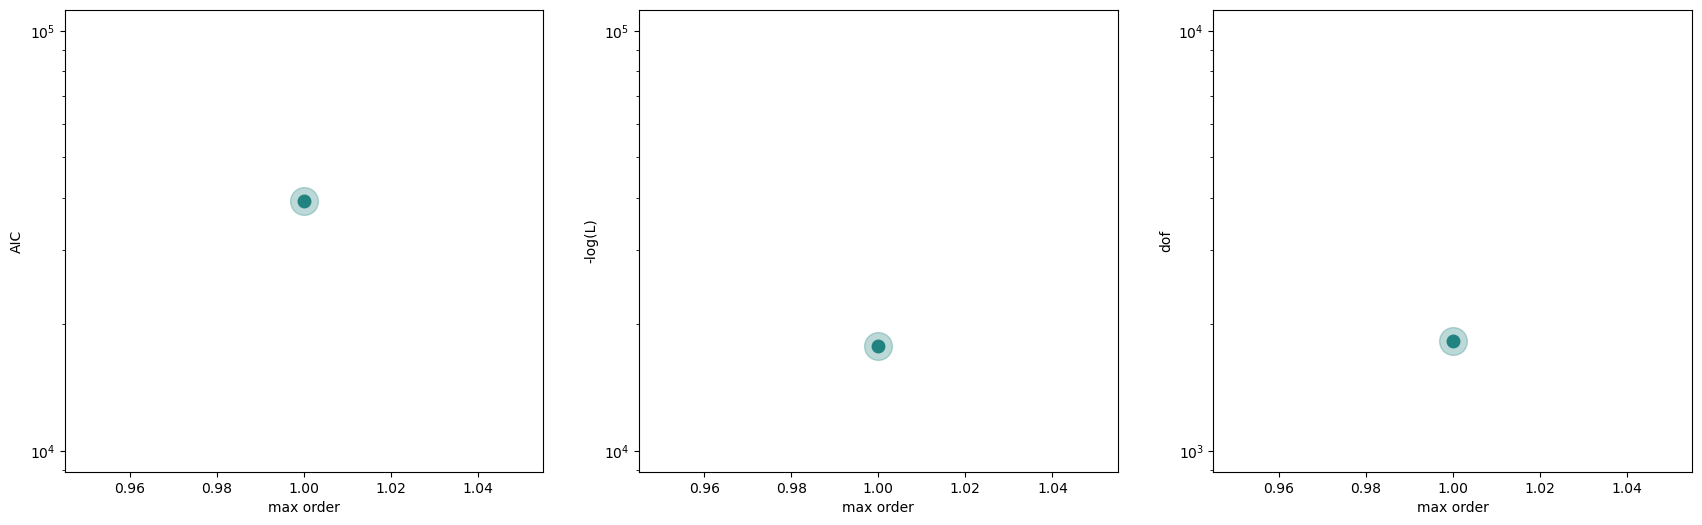

In [5]:
model.model.plot()

In [6]:
# Load test data from file
traj_path_prefix = '../../data/processed/'
all_test_paths = dataloader_paths.load_path_test_data(path_prefix, network_name, test_dates, 
                                                      0, -1, 1, data_version='')
test_trajectories = dataloader_geo.load_trajectories(traj_path_prefix, location, network.crs, test_dates)

In [7]:
##### Prediction parameters ######
prediction_task = 'next_nodes'  # 'next_nodes' or 'path'
n_walks = 1000
n_start_nodes = 1
n_steps = 1        # only needed for next nodes prediction
n_predictions = 1

# select test data
selection_start = 0
selection_end = -1
selection_step = 20

if prediction_task == 'next_nodes':
    # split test paths in subpaths
    sub_paths = dataloader_paths.split_path_data(all_test_paths, n_steps+1)
    if selection_end == -1:
        selection_end = len(sub_paths)
    selection = np.arange(selection_start, selection_end, selection_step)
    test_paths = sub_paths.iloc[selection]
else:
    if selection_end == -1:
        selection_end = len(all_test_paths)
    selection = np.arange(selection_start, selection_end, selection_step)
    test_paths = all_test_paths.iloc[selection]

In [8]:
# make predictions
predictions = model.predict(prediction_task, test_paths, network.G, 
                            n_start_nodes=n_start_nodes, n_steps=n_steps, 
                            n_predictions=n_predictions, n_walks=n_walks)

Making predictions for 1879 samples
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done!


Evaluating 1879 samples for next_nodes prediction task
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done!


Time elapsed: 0.04 minutes


Percentage of unsuccessful predictions: 0.00%
Mean SSPD: 66.06m
Median SSPD: 0.00m
Mean choice_accuracy: 0.8057


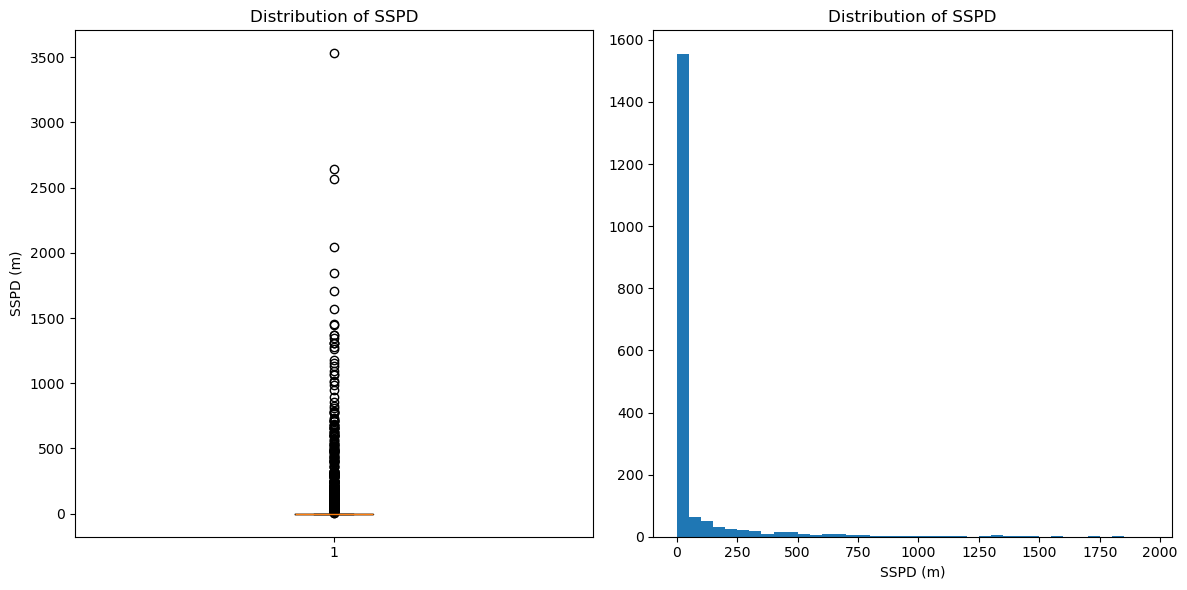

In [9]:
# evaluate
eval_mode = 'path'
evaluation_results, fig = metrics.evaluate_given_predictions(prediction_task, predictions, test_trajectories, 
                                                             network, n_start_nodes=n_start_nodes, n_steps=n_steps, eval_mode=eval_mode)

In [10]:
for i in range(0, len(predictions)):
    print(predictions['prediction'].iloc[i])

(130, 129)
(532, 531)
(2, 269)
(484, 485)
(538, 534)
(373, 376)
(296, 297)
(406, 408)
(435, 436)
(462, 25)
(341, 342)
(501, 500)
(300, 306)
(470, 464)
(129, 128)
(494, 452)
(266, 265)
(359, 374)
(445, 444)
(265, 264)
(332, 328)
(315, 317)
(156, 148)
(285, 286)
(515, 520)
(291, 292)
(351, 364)
(520, 535)
(399, 368)
(223, 236)
(526, 525)
(270, 273)
(178, 224)
(453, 443)
(242, 395)
(504, 505)
(7, 445)
(383, 384)
(458, 467)
(360, 320)
(152, 141)
(510, 509)
(352, 359)
(95, 96)
(223, 236)
(525, 516)
(272, 266)
(289, 290)
(492, 497)
(512, 510)
(357, 361)
(363, 362)
(284, 287)
(538, 534)
(368, 369)
(309, 315)
(406, 408)
(129, 128)
(532, 531)
(538, 534)
(386, 303)
(515, 520)
(427, 423)
(128, 4)
(499, 501)
(2, 269)
(352, 359)
(294, 302)
(443, 431)
(471, 476)
(540, 538)
(433, 428)
(386, 303)
(483, 482)
(438, 440)
(435, 436)
(497, 498)
(387, 394)
(499, 501)
(444, 448)
(527, 528)
(187, 6)
(455, 459)
(443, 431)
(263, 3)
(503, 484)
(539, 540)
(376, 377)
(434, 435)
(57, 56)
(437, 34)
(11, 10)
(165, 34

In [11]:
evaluation_results

,mmsi,true_path,predicted_path,distances,SSPD,choice_accuracy
0,210055000_0_2022-06-01 09:31:46,"(130, 129)","(130, 129)",[0],0,1.0
0,210055000_0_2022-06-01 09:31:46,"(532, 531)","(532, 531)",[0],0,1.0
0,210055000_0_2022-06-01 09:31:46,"(2, 269)","(2, 269)",[0],0,1.0
0,210055000_8_2022-06-01 20:12:01,"(484, 485)","(484, 485)",[0],0,1.0
0,210055000_8_2022-06-01 20:12:01,"(538, 534)","(538, 534)",[0],0,1.0
...,...,...,...,...,...,...
0,314318000_5_2022-06-07 01:38:31,"(340, 334)","(340, 334)",[0],0,1.0
0,314318000_6_2022-06-08 18:01:01,"(474, 470)","(474, 470)",[0],0,1.0
0,314631000_0_2022-06-09 14:42:08,"(309, 315)","(309, 315)",[0],0,1.0
0,314631000_0_2022-06-09 14:42:08,"(5, 300)","(5, 300)",[0],0,1.0


In [12]:
# plot predictions with the MOGen model
prediction_task = 'next_nodes'
example = test_paths.iloc[3]
mmsi = example.mmsi
start_node = [example.path[0]]
end_node = example.path[-1]
true_path = example.path
trajectory = test_trajectories.get_trajectory(mmsi)

if prediction_task == 'next_nodes':
    predictions = model.predict_next_nodes(start_node=start_node, G=network.G, n_predictions=3, n_steps=3, n_walks=200)
if prediction_task == 'path':
    predictions, flag = model.predict_path(start_node, end_node, network.G, n_predictions=5, n_walks=2000, verbose=True)

map = visualize.map_prediction_and_ground_truth(predictions, start_node, trajectory, true_path, network, 
                                                min_passages=1, opacity=0.2, location=location, end_node=end_node)
map.save('../../reports/maps/'+network_name+'_MOGen_predictions.html')
print(f'Map saved under {"../../reports/maps/"+network_name+"_MOGen_predictions.html"}')

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.31it/s]


Map saved under ../../reports/maps/202204_waypoints_DP10_HDBSCAN13_tromso_full_UTM_MOGen_predictions.html
